In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [2]:
labels = pd.read_csv("spatial_sim_data/labels.csv", names = ["path", "N"])
print(labels.iloc[0:10,:])

                                           path    N
0  input_matrices/spatial_sim_parents_500_0.csv  531
1  input_matrices/spatial_sim_parents_500_1.csv  525
2  input_matrices/spatial_sim_parents_500_2.csv  532
3  input_matrices/spatial_sim_parents_500_3.csv  539
4  input_matrices/spatial_sim_parents_500_4.csv  528
5  input_matrices/spatial_sim_parents_500_5.csv  547
6  input_matrices/spatial_sim_parents_500_6.csv  521
7  input_matrices/spatial_sim_parents_500_7.csv  523
8  input_matrices/spatial_sim_parents_500_8.csv  543
9  input_matrices/spatial_sim_parents_500_9.csv  530


In [3]:
parents_file = "spatial_sim_data/spatial_parents/spatial_sim_parents_500_0.csv"
n = 150
parents = pd.read_csv(parents_file)
#parents.columns = ['individual', 'parent1', 'parent2', 'x', 'y', 'age']
print(parents)
N = len(parents)
sample_rows = rng.choice(np.arange(N), n, replace = False)


     individual   parent1   parent2         x         y   age
0       11519.0   10550.0   10550.0  0.897136  0.423633  88.0
1       11729.0   10829.0   10829.0  0.229187  0.078204  84.0
2       12251.0   11980.0   11980.0  0.866318  0.323394  75.0
3       12580.0   11146.0   11146.0  0.838571  0.300380  68.0
4       12632.0   12176.0   12176.0  0.264359  0.824464  67.0
..          ...       ...       ...       ...       ...   ...
526     16181.0   16052.0   16052.0  0.522768  0.772153   0.0
527     16182.0   15364.0   15364.0  0.986324  0.209085   0.0
528     16183.0   12786.0   12786.0  0.926631  0.828131   0.0
529     16185.0   15590.0   15590.0  0.023032  0.462635   0.0
530     16186.0   14721.0   14721.0  0.460829  0.660411   0.0

[531 rows x 6 columns]


In [94]:
n_rows_input = 100
kin_file = pd.read_csv("spatial_sim_data/input_matrices/spatial_sim_parents_500_0.csv", header = 0)
kin_file = kin_file.sort_values(by = ['# parent0of1', ' parent1of0'], axis = 0, ascending = False).to_numpy()
#print(kin_file[0:30, :])
np0of1 = sum(kin_file[:, 0])
np1of0 = sum(kin_file[:, 1])
po_total = int(np0of1 + np1of0)
print(po_total)
kin_po = kin_file[0:po_total,:]
kin_notpo = kin_file[po_total:,:]
padding_rows_i = rng.choice(np.arange(len(kin_notpo)), n_rows_input - len(kin_po), replace = False)
padding = kin_notpo[padding_rows_i, :]
input_matrix = np.concatenate((kin_po, padding))
print(input_matrix)
#print(kin_po)
#print(kin_notpo)

26
[[1.00000e+00 0.00000e+00 2.60086e-01 3.82743e-01 2.73930e-01 4.47452e-01
  1.70000e+01 5.00000e+00]
 [1.00000e+00 0.00000e+00 8.31766e-01 7.93029e-01 8.07164e-01 7.63303e-01
  1.00000e+01 6.00000e+00]
 [1.00000e+00 0.00000e+00 5.69870e-01 3.15943e-01 5.68245e-01 2.70282e-01
  1.00000e+01 2.00000e+00]
 [1.00000e+00 0.00000e+00 4.08675e-01 3.67444e-01 3.99247e-01 3.51329e-01
  8.00000e+00 4.00000e+00]
 [1.00000e+00 0.00000e+00 7.52214e-01 2.12063e-01 7.85198e-01 2.15007e-01
  2.70000e+01 1.00000e+00]
 [1.00000e+00 0.00000e+00 2.64359e-01 8.24464e-01 3.17089e-01 8.22454e-01
  6.70000e+01 1.60000e+01]
 [1.00000e+00 0.00000e+00 3.13588e-01 7.31879e-01 3.07115e-01 7.49895e-01
  3.00000e+00 2.00000e+00]
 [1.00000e+00 0.00000e+00 9.34533e-01 7.86800e-01 9.55437e-01 8.16631e-01
  6.40000e+01 3.40000e+01]
 [1.00000e+00 0.00000e+00 9.93943e-01 6.27039e-01 1.22366e-02 6.13713e-01
  8.00000e+00 4.00000e+00]
 [0.00000e+00 1.00000e+00 9.26631e-01 8.28131e-01 9.34533e-01 7.86800e-01
  0.00000e+00 

In [77]:
class KinDataset(Dataset):
    def __init__(self, base_folder, input_rows):
        self.labels = pd.read_csv(base_folder + "/labels.csv", names = ["path", "N"])
        self.base_folder = base_folder
        self.input_rows = input_rows
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        kin_file = pd.read_csv("spatial_sim_data/input_matrices/spatial_sim_parents_500_0.csv", header = 0)
        kin_file = kin_file.sort_values(by = ['# parent0of1', ' parent1of0'], axis = 0, ascending = False).to_numpy()
        np0of1 = sum(kin_file[:, 0])
        np1of0 = sum(kin_file[:, 1])
        po_total = int(np0of1 + np1of0)
        kin_po = kin_file[0:po_total,:]
        kin_notpo = kin_file[po_total:,:]
        padding_rows_i = rng.choice(np.arange(len(kin_notpo)), self.input_rows - len(kin_po), replace = False)
        padding = kin_notpo[padding_rows_i, :]
        input_matrix = np.concatenate((kin_po, padding))
        input_tensor = torch.from_numpy(input_matrix).float()
        input_tensor = input_tensor.unsqueeze(0)
        label = torch.tensor([self.labels.iloc[idx, 1]]).float()
        return input_tensor, label
    
kin_dataset = KinDataset("spatial_sim_data", 100)

In [78]:
kin_dataset[0]

(tensor([[[1.0000e+00, 0.0000e+00, 2.6009e-01, 3.8274e-01, 2.7393e-01,
           4.4745e-01, 1.7000e+01, 5.0000e+00],
          [1.0000e+00, 0.0000e+00, 8.3177e-01, 7.9303e-01, 8.0716e-01,
           7.6330e-01, 1.0000e+01, 6.0000e+00],
          [1.0000e+00, 0.0000e+00, 5.6987e-01, 3.1594e-01, 5.6824e-01,
           2.7028e-01, 1.0000e+01, 2.0000e+00],
          [1.0000e+00, 0.0000e+00, 4.0867e-01, 3.6744e-01, 3.9925e-01,
           3.5133e-01, 8.0000e+00, 4.0000e+00],
          [1.0000e+00, 0.0000e+00, 7.5221e-01, 2.1206e-01, 7.8520e-01,
           2.1501e-01, 2.7000e+01, 1.0000e+00],
          [1.0000e+00, 0.0000e+00, 2.6436e-01, 8.2446e-01, 3.1709e-01,
           8.2245e-01, 6.7000e+01, 1.6000e+01],
          [1.0000e+00, 0.0000e+00, 3.1359e-01, 7.3188e-01, 3.0711e-01,
           7.4989e-01, 3.0000e+00, 2.0000e+00],
          [1.0000e+00, 0.0000e+00, 9.3453e-01, 7.8680e-01, 9.5544e-01,
           8.1663e-01, 6.4000e+01, 3.4000e+01],
          [1.0000e+00, 0.0000e+00, 9.9394e-01, 6

In [79]:
n_total = len(kin_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [80]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

2500
1250
1250


In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [82]:
kin_dataset[0][0].size()

torch.Size([1, 100, 8])

In [83]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

In [84]:
x = torch.ones((4, 1, 100, 8))
model(x).shape

torch.Size([4, 64, 25, 2])

In [85]:
model.add_module('flatten', nn.Flatten()) 

In [86]:
x = torch.ones((4, 1, 100, 8))
model(x).shape

torch.Size([4, 3200])

In [87]:
model.add_module('fc1', nn.Linear(3200, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 
model.add_module('fc2', nn.Linear(1024, 1)) 

In [88]:
x = torch.ones((4, 1, 100, 8))
model(x).shape

torch.Size([4, 1])

In [89]:
model = model.to(device) 

In [90]:
loss_fn = nn.HuberLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 256.3724 val_loss: 153.7481
Epoch 2 loss: 162.7241 val_loss: 161.6954
Epoch 3 loss: 161.1029 val_loss: 187.9641
Epoch 4 loss: 175.9560 val_loss: 150.8653
Epoch 5 loss: 161.8142 val_loss: 156.1942
Epoch 6 loss: 158.4780 val_loss: 184.7635
Epoch 7 loss: 161.6010 val_loss: 153.8497
Epoch 8 loss: 163.4361 val_loss: 152.2455
Epoch 9 loss: 160.8558 val_loss: 150.4302
Epoch 10 loss: 162.1778 val_loss: 175.8827
Epoch 11 loss: 167.2431 val_loss: 156.5040
Epoch 12 loss: 159.8195 val_loss: 160.5802
Epoch 13 loss: 159.3020 val_loss: 150.7285
Epoch 14 loss: 159.8240 val_loss: 150.4564
Epoch 15 loss: 157.8314 val_loss: 150.1470
Epoch 16 loss: 157.3441 val_loss: 162.8105
Epoch 17 loss: 158.5233 val_loss: 158.2082
Epoch 18 loss: 158.2185 val_loss: 172.5262
Epoch 19 loss: 163.4583 val_loss: 159.6958
Epoch 20 loss: 158.7737 val_loss: 153.8298


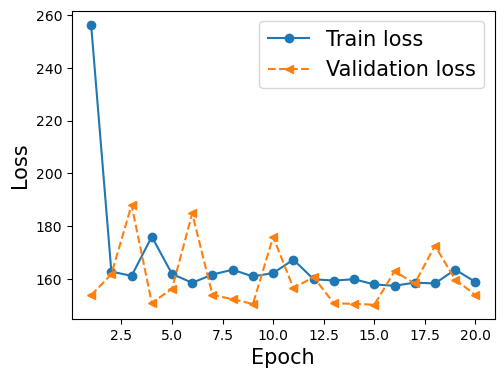

In [91]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [92]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        #test_pred[i] = test_output.numpy()
        #test_truth[i] = test_output[0].numpy()
        #test_pred[i] = model(test_input)[0, 0].numpy()

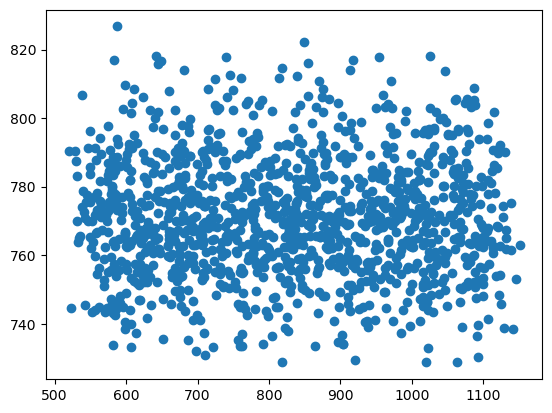

In [93]:
plt.scatter(test_truth, test_pred)
#plt.plot([500, 1000], [500, 1000])